# Kimberlite eruptions

Import the kimberlite dataset from [Giuliani and Pearson (2019)](https://doi.org/10.2138/GSELEMENTS.15.6.377) and resample them on a tessellated spherical mesh using [stripy](https://github.com/underworldcode/stripy).

#### References

- Giuliani, A., & Pearson, D. G. (2019). Kimberlites: From deep earth to diamond mines. Elements, 15(6), 377–380. https://doi.org/10.2138/GSELEMENTS.15.6.377
- Moresi, L., & Mather, B. (2019). Stripy: A Python module for (constrained) triangulation in Cartesian coordinates and on a sphere. Journal of Open Source Software, 4(38), 1410. https://doi.org/10.21105/joss.01410


In [26]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

import stripy
from scipy.spatial import SphericalVoronoi

%matplotlib inline

In [4]:
# kimberlite dataset
df_kimberlite = pd.read_excel("data/v15n6_1-Guiliani_Pearson_supplement_Kimberlite_localities_database_RDM.xlsx",
                              skiprows=2)

df_kimberlite_all = df_kimberlite.copy()

# clean up database
df_kimberlite = df_kimberlite[~np.isnan(df_kimberlite['Age estimated RDM'])]
df_kimberlite = df_kimberlite[~np.isnan(df_kimberlite['Longitude'])]
df_kimberlite = df_kimberlite[~np.isnan(df_kimberlite['Latitude'])]
df_kimberlite = df_kimberlite[df_kimberlite['Age estimated RDM'] <= 250]
kimberlite_age = df_kimberlite['Age estimated RDM'].to_numpy()

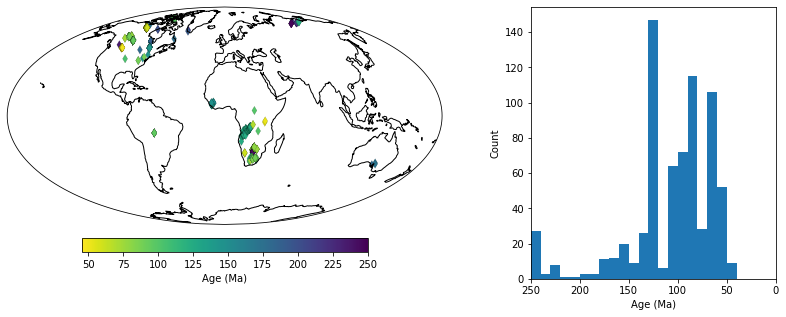

In [51]:
fig = plt.figure(figsize=(15,5))

gs = GridSpec(1,2, wspace=0.05, width_ratios=[0.7,0.3])

ax1 = fig.add_subplot(gs[0], projection=ccrs.Mollweide())
ax1.set_global()
ax1.coastlines()
sc1 = ax1.scatter(df_kimberlite['Longitude'], df_kimberlite['Latitude'], c=kimberlite_age, marker='d',
                  edgecolor='k', linewidth=0.1, cmap='viridis_r', transform=ccrs.PlateCarree(), vmax=250)

fig.colorbar(sc1, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.5, label='Age (Ma)')

ax2 = fig.add_subplot(gs[1], xlabel='Age (Ma)', ylabel='Count', xlim=(250,0))
ax2.hist(kimberlite_age, bins=25, range=(0,250))
plt.show()

## Condense kimberlites

Bin the kimberlites into (roughly) equal-area tessellation.

In [56]:
mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=False, tree=True)
area = mesh.areas() * 6371**2

# vlon, vlat = mesh.voronoi_points()
# vx, vy, vz = stripy.spherical.lonlat2xyz(vlon, vlat)

# vor = SphericalVoronoi(np.c_[vx, vy, vz])
# area = vor.calculate_areas()
# area *= 6371**2 # convert to km

print("min area  {:.2f} km^2".format(area.min()))
print("mean area {:.2f} km^2".format(area.mean()))
print("max area  {:.2f} km^2".format(area.max()))
print("")
print("min distance  {:.2f} km".format(np.sqrt(area.min())))
print("mean distance {:.2f} km".format(np.sqrt(area.mean())))
print("max distance  {:.2f} km".format(np.sqrt(area.max())))

min area  370308.92 km^2
mean area 398487.87 km^2
max area  479165.68 km^2

min distance  608.53 km
mean distance 631.26 km
max distance  692.22 km


In [57]:
containing_triangles = np.zeros(df_kimberlite_all.shape[0], dtype=int)

for i in range(0, df_kimberlite_all.shape[0]):
    klon = np.radians(df_kimberlite_all['Longitude'][i])
    klat = np.radians(df_kimberlite_all['Latitude'][i])
    
    if np.isfinite([klon, klat]).all():
        tri = mesh.containing_triangle(klon, klat)
        containing_triangles[i] = int(tri)

In [58]:
# find triangle centroids
cxyz = mesh.points[mesh.simplices].mean(axis=1)
centroid_lon, centroid_lat = stripy.spherical.xyz2lonlat(cxyz[:,0], cxyz[:,1], cxyz[:,2])
centroid_lon = np.degrees(centroid_lon)
centroid_lat = np.degrees(centroid_lat)

# now average like-ages
unique_containing_triangles = np.unique(containing_triangles)

# diamond look-up dictionary
DM_dict = {'(DM)': 1, "DM": 1, "NON-DM": 0, "non-DM": 0, "Non-DM": 0, "(Non-DM)": 0, "Unknow": 2, np.nan: 2}


df_kimb = pd.DataFrame(columns=['Longitude', 'Latitude', 'Diamonds', 'Age estimated RDM'])

for i, tri in enumerate(unique_containing_triangles):
    mask_triangles = containing_triangles == tri
    
    c_lon = np.nanmean(df_kimberlite_all['Longitude'][mask_triangles])
    c_lat = np.nanmean(df_kimberlite_all['Latitude'][mask_triangles])
    
    ages = df_kimberlite_all['Age estimated RDM'][mask_triangles]
    DM_codes = df_kimberlite_all['Diamonds'][mask_triangles]
    
    DM = np.zeros(np.count_nonzero(mask_triangles), dtype=int)
    
    for j, DM_code in enumerate(DM_codes):
        DM[j] = DM_dict[DM_code]
    
    DM_code = np.bincount(DM, minlength=3).argmax()
    
    if np.isfinite(ages).any():
        
        # cluster into ages
        hist, age_range = np.histogram(ages, range=(0, 2000), bins=200)
        age_group = age_range[:-1][hist > 0]
        
        for age in age_group:
            df_kimb.loc[len(df_kimb.index)] = [c_lon, c_lat, DM_code, age]

/var/folders/cw/2gdtjqwj6f9blylnp_6wxgvh0000gn/T/ipykernel_14431/1634198184.py:19: RuntimeWarning: Mean of empty slice
  c_lon = np.nanmean(df_kimberlite_all['Longitude'][mask_triangles])
/var/folders/cw/2gdtjqwj6f9blylnp_6wxgvh0000gn/T/ipykernel_14431/1634198184.py:20: RuntimeWarning: Mean of empty slice
  c_lat = np.nanmean(df_kimberlite_all['Latitude'][mask_triangles])


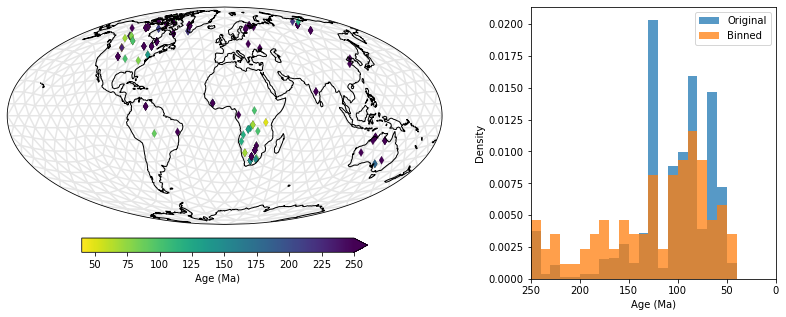

In [68]:
fig = plt.figure(figsize=(15,5))

gs = GridSpec(1,2, wspace=0.05, width_ratios=[0.7,0.3])

ax1 = fig.add_subplot(gs[0], projection=ccrs.Mollweide())
ax1.set_global()
ax1.coastlines()

# tessellation
ax1.triplot(np.rad2deg(mesh.lons), np.rad2deg(mesh.lats), mesh.simplices, transform=ccrs.Geodetic(), color='0.9')

sc1 = ax1.scatter(df_kimb['Longitude'], df_kimb['Latitude'], c=df_kimb["Age estimated RDM"], marker='d',
                  edgecolor='k', linewidth=0.1, cmap='viridis_r', transform=ccrs.PlateCarree(), vmax=250)

fig.colorbar(sc1, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.5, label='Age (Ma)', extend='max')

ax2 = fig.add_subplot(gs[1], xlabel='Age (Ma)', ylabel='Density', xlim=(250,0))
ax2.hist(kimberlite_age, bins=25, range=(0,250), density=True, alpha=0.75, label='Original')
ax2.hist(df_kimb["Age estimated RDM"], bins=25, range=(0,250), density=True, alpha=0.75, label='Binned')
ax2.legend()
plt.show()

In [69]:
df_kimb.to_excel("data/kimberlites_condensed.xlsx")